In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from config import api_key
import matplotlib.pyplot as plt 

In [2]:
# Locate CSV files and convert to dataframes
STATE_DATA_PATH = "Resources/MN_2020_ADI_9 Digit Zip Code_v3.2.csv"
LOCAL_DATA_PATH = "Resources/Local_Repository_Data.csv"
PT_DATA_PATH = "Resources/Patient_Data.csv"

state_df = pd.read_csv(STATE_DATA_PATH)
local_df = pd.read_csv(LOCAL_DATA_PATH)
pt_df = pd.read_csv(PT_DATA_PATH)

C:\Users\rolis\AppData\Local\Temp\ipykernel_29264\2531968484.py:6: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  state_df = pd.read_csv(STATE_DATA_PATH)


# DATA CLEANING
---
state_df cleaning

In [3]:
state_df.head()

,ZIP_4,GISJOIN,FIPS,ADI_NATRANK,ADI_STATERANK,TYPE
0,550010002,G27016300711022,2.716307e+11,12,1,
1,550010003,G27016300711022,2.716307e+11,12,1,
2,550010004,G27016300711022,2.716307e+11,12,1,
3,550010001,G27016300711022,2.716307e+11,12,1,
4,550010015,G27016300711022,2.716307e+11,12,1,


In [4]:
# Over 1.2 million MN zip codes are in state_df
state_df.shape[0]


1207314

In [4]:
# Drop unwanted columns from state_df
clean_state_df = state_df.drop(["GISJOIN", "FIPS", "TYPE"], axis=1)
clean_state_df.head()

,ZIP_4,ADI_NATRANK,ADI_STATERANK
0,550010002,12,1
1,550010003,12,1
2,550010004,12,1
3,550010001,12,1
4,550010015,12,1


In [5]:
# Find bad data to drop
clean_state_df["ADI_STATERANK"].unique()

array(['1', '4', '3', '6', 'GQ-PH', '2', '5', '9', '8', '7', 'GQ', '10',
       'PH', nan, 8, 10, 7, 4, 9, 5, 6, 3, 1], dtype=object)

In [6]:
# Drop bad data
clean_state_df = clean_state_df.loc[(clean_state_df["ADI_STATERANK"] != "GQ") &
                                    (state_df["ADI_STATERANK"] != "PH") &
                                    (state_df["ADI_STATERANK"] != "GQ-PH")]
clean_state_df["ADI_STATERANK"].unique()

array(['1', '4', '3', '6', '2', '5', '9', '8', '7', '10', nan, 8, 10, 7,
       4, 9, 5, 6, 3, 1], dtype=object)

In [8]:
# Drop NaN data
clean_state_df = clean_state_df.dropna()

In [9]:
# Confirm that all bad data is dropped from ADI_STATERANK column
clean_state_df["ADI_STATERANK"].unique()

array(['1', '4', '3', '6', '2', '5', '9', '8', '7', '10', 8, 10, 7, 4, 9,
       5, 6, 3, 1], dtype=object)

In [10]:
# Confirm that all bad data is dropped from ADI_NATRANK column
clean_state_df["ADI_NATRANK"].unique()

array(['12', '11', '16', '35', '10', '39', '31', '50', '27', '42', '45',
       '22', '37', '74', '43', '62', '46', '40', '47', '34', '56', '67',
       '68', '69', '66', '70', '63', '41', '48', '38', '36', '57', '28',
       '25', '33', '29', '26', '30', '19', '55', '32', '49', '20', '18',
       '24', '23', '53', '54', '97', '14', '59', '15', '21', '17', '44',
       '73', '64', '81', '61', '58', '76', '60', '13', '9', '51', '8',
       '98', '5', '75', '86', '72', '65', '96', '84', '95', '77', '71',
       '82', '83', '6', '92', '52', '89', '80', '79', '78', '7', '99',
       '4', '100', '3', '2', '91', '85', '87', '93', '88', '94', '90', 60,
       62, 61, 96, 55, 63, 59, 39, 67, 44, 69, 42, 43, 74, 64, 79, 81, 70,
       77, 54, 68, 51, 46, 58, 52, 72, 82, 75, 80, 88, 56, 76, 45, 34, 90,
       65, 99, 40, 36, 78, 84, 83, 73, 86, 66, 31, 53, 50, 85],
      dtype=object)

In [11]:
# Reset the index after dropping rows
clean_state_df = clean_state_df.reset_index(drop=True)
clean_state_df.head()

,ZIP_4,ADI_NATRANK,ADI_STATERANK
0,550010002,12,1
1,550010003,12,1
2,550010004,12,1
3,550010001,12,1
4,550010015,12,1


In [12]:
# Almost 30,000 rows were dropped during data cleaning
print(state_df.shape[0] - clean_state_df.shape[0])

29462


In [13]:
# Rename zip code column name to match the pt_data_df
clean_state_df = clean_state_df.rename(columns={"ZIP_4": "Zip Code (9-digit)"})
clean_state_df.head()

,Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK
0,550010002,12,1
1,550010003,12,1
2,550010004,12,1
3,550010001,12,1
4,550010015,12,1


---
local_df cleaning

In [14]:
local_df.head()

,Local Repository ID,Zip Code (5-digit),Zip Code (9-digit),Established
0,101,55407,554074563,7/9/2021
1,102,56377,563771274,7/1/2021
2,103,55454,554544400,6/10/2021
3,104,55416,554162527,7/15/2022
4,105,56441,564411422,7/21/2022


In [15]:
# RoundtableRx has 22 local repositories where patients can get their medications
local_df.shape[0]

22

In [16]:
# Drop unwanted columns
clean_local_df = local_df.drop("Established", axis=1)
clean_local_df.head()

,Local Repository ID,Zip Code (5-digit),Zip Code (9-digit)
0,101,55407,554074563
1,102,56377,563771274
2,103,55454,554544400
3,104,55416,554162527
4,105,56441,564411422


In [17]:
# Check for bad data
clean_local_df["Zip Code (5-digit)"].unique()

array([55407, 56377, 55454, 55416, 56441, 56401, 56636, 56501, 55063,
       55807, 55470, 55987, 55404, 55104, 55409, 55054, 55303, 55805],
      dtype=int64)

In [18]:
# Check for bad data
clean_local_df["Zip Code (9-digit)"].unique()

array([554074563, 563771274, 554544400, 554162527, 564411422, 564013575,
       566368779, 565013503, 550636026, 564013054, 558072730, 554071131,
       559876435, 558072737, 554043074, 551044201, 554091304, 554044515,
       550545483, 554042923, 553035566, 558051901], dtype=int64)

----
pt_df cleaning

In [19]:
pt_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit),Date Started or Renewed
0,113,2001,55987,559874346,1/30/2023
1,115,2002,55429,554292726,5/18/2021
2,115,2003,??,??,6/2/2021
3,115,2004,55407,554071135,8/20/2021
4,115,2005,55428,554282966,7/22/2022


In [20]:
# RoundtableRx serves 133 unique patients
pt_df.shape[0]

133

In [21]:
# Drop unwanted columns
clean_pt_df = pt_df.drop("Date Started or Renewed", axis=1)
clean_pt_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit)
0,113,2001,55987,559874346
1,115,2002,55429,554292726
2,115,2003,??,??
3,115,2004,55407,554071135
4,115,2005,55428,554282966


In [22]:
# Check for bad data
clean_pt_df["Zip Code (5-digit)"].unique()

array(['55987', '55429', '??', '55407', '55428', '55417', '55434',
       '55418', '55413', '55423', '56679', '55792', '55810', '55720',
       '56649', '55804', '55805', '56401', '55807', '55724', '55705',
       '55812', '55795', '56470', '55803', '56636', '55753', '56571',
       '56573', '55797', '55744', '55811', '56484', '55760', '55782',
       '56450', '56672', '56501', '55779', '56473', '56474', '56554',
       '56637', '56544', '56449', '55722', '56655', '55020', '55044',
       '55088', '55054', '55378', '55057', '55616', '55454', '55106',
       '55406', '55303', '55126', '55433', '55343', '55304', '55025',
       '55387', '55117', '55346', '55110', '55362', '55404', '56444',
       '56441', '55119'], dtype=object)

In [23]:
# Check for bad data
clean_pt_df["Zip Code (9-digit)"].unique()

array(['559874346', '554292726', '??', '554071135', '554282966',
       '554172816', '554195500', '554072203', '554184420', '554131969',
       '554234333', '566790093', '557922844', '558109576', '557201311',
       '566493402', '558041646', '557922200', '558052044', '564012737',
       '566492805', '558072658', '557248533', '557051441', '558051823',
       '558043301', '558121751', '557953076', '558052073', '564701387',
       '558072542', '558043061', '558039436', '566360179', '557530641',
       '565719409', '565739010', '566363071', '557978718', '557442177',
       '557248209', '558111236', '564842171', '557605894', '557820385',
       '564509694', '566724575', '565012449', '558032034', '557797006',
       '566360395', '565013203', '566362044', '564732139', '558102022',
       '557923527', '558041806', '558121720', '558115323', '564014402',
       '566362205', '564746164', '565549002', '566372091', '565012909',
       '565448547', '558071922', '558071908', '558031945', '564491107',

In [24]:
# Drop bad data
clean_pt_df = clean_pt_df.loc[(clean_pt_df["Zip Code (9-digit)"] != "??") & (clean_pt_df["Zip Code (5-digit)"] != "??")]
clean_pt_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit)
0,113,2001,55987,559874346
1,115,2002,55429,554292726
3,115,2004,55407,554071135
4,115,2005,55428,554282966
5,115,2006,55417,554172816


In [25]:
# Reset the index after dropping rows
clean_pt_df = clean_pt_df.reset_index(drop=True)
clean_pt_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit)
0,113,2001,55987,559874346
1,115,2002,55429,554292726
2,115,2004,55407,554071135
3,115,2005,55428,554282966
4,115,2006,55417,554172816


In [26]:
# Four patients were dropped during data cleaning
print(pt_df.shape[0] - clean_pt_df.shape[0])

4


# Data Merging

In [27]:
# Before merging clean_pt_df and clean_state_df, ensure that common column is of the same dtype
clean_pt_df['Zip Code (9-digit)'] = clean_pt_df['Zip Code (9-digit)'].astype(int)
clean_state_df['Zip Code (9-digit)'] = clean_state_df['Zip Code (9-digit)'].astype(int)

In [28]:
# Merge clean_pt_df and clean_state_df so that we can get the ADI rank of each patient
pt_adi_df = pd.merge(clean_pt_df,clean_state_df, how="inner", on=["Zip Code (9-digit)", "Zip Code (9-digit)"])
pt_adi_df.head()

,Local Repository ID,Patient ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK
0,113,2001,55987,559874346,77,10
1,115,2002,55429,554292726,62,8
2,115,2004,55407,554071135,57,7
3,115,2005,55428,554282966,63,8
4,115,2006,55417,554172816,84,10


In [29]:
# The ADI score was available for 127 of RoundtableRxs patients
pt_adi_df.shape[0]

127

In [30]:
# Before merging clean_local_df and clean_state_df, ensure that common column is of the same dtype
clean_local_df['Zip Code (9-digit)'] = clean_local_df['Zip Code (9-digit)'].astype(int)

In [31]:
# Merge clean_local_df and clean_state_df so that we can get the ADI rank of each local repository
local_adi_df = pd.merge(clean_local_df,clean_state_df, how="left", on=["Zip Code (9-digit)", "Zip Code (9-digit)"])
local_adi_df.head(1000)

,Local Repository ID,Zip Code (5-digit),Zip Code (9-digit),ADI_NATRANK,ADI_STATERANK
0,101,55407,554074563,44,5
1,102,56377,563771274,65,8
2,103,55454,554544400,NaN,NaN
3,104,55416,554162527,41,5
4,105,56441,564411422,58,7
5,106,56401,564013575,84,10
6,107,56636,566368779,90,10
7,108,56501,565013503,75,9
8,109,55063,550636026,63,8
9,110,56401,564013054,73,9


1.using geoapify (https://apidocs.geoapify.com/docs/geocoding/forward-geocoding/#geocode-zipcodes) add lat and lon columns as well get a county column to pt_adi_df and local_adi_df. get county column added to clean_state_df.
    - Ayan
    Travis

make the maps

2. get mean, mode for pt_adi_df ADI_STATERANK and ADI_NATRANK
    - Kokoe

make bar charts y = # of pts, x = ADIs core for pt_adi_df. state ranks only
    - Roli

3. pie chart ADI scores
    - Joanna

4. health access / health outcomes vs adi score per county

to create a new branch:     git checkout -b new-branch-name
to push to a branch:        git push origin new-branch-name

10 AM GROUP ON SATURDAY

2:30 GROUP ON SATURDAY


In [73]:
pt_adi_df['ADI_STATERANK'] = pt_adi_df['ADI_STATERANK'].astype(int)

pt_adi_df['ADI_STATERANK'].unique()


array([10,  8,  7,  1,  6,  5,  4,  9,  3,  2])

# Visualization
*Bar Chart*

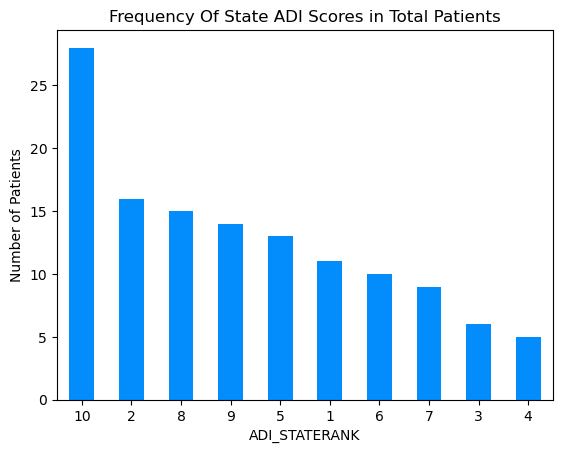

In [80]:
#barcharts for ADI scores for state ranks
API_state = pt_adi_df['ADI_STATERANK'].value_counts()
API_state.plot(kind = "bar",color ='#038cfc')

plt.xlabel('ADI_STATERANK')
plt.ylabel("Number of Patients")
plt.title("Frequency Of State ADI Scores in Total Patients")
plt.xticks(rotation = 'horizontal')
plt.show()